Pobieramy dane. Alternatywnie z zapisanego pliku lokalnie.
Źródło danych: (GPW) https://www.gpw.pl/archiwum-notowan

In [1]:
import pandas as pd
import numpy as np

# get data
url = 'https://drive.google.com/file/d/1VfvaefBkfg0fvEkDwgBep10Vs3T5egWH/view?usp=sharing'
path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]

df = pd.read_csv(path)
df['Data'] = pd.to_datetime(df['Data'])
df = df.set_index('Data')

Wykres

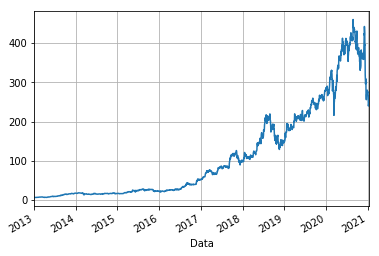

In [3]:
df['close'].plot(logy=False, grid=True)

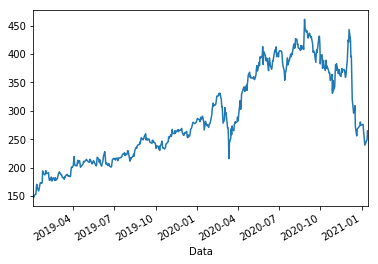

In [4]:
# wykres w skali log
df['close'][df.index>'2019-01-01'].plot() 

Regresja liniowa

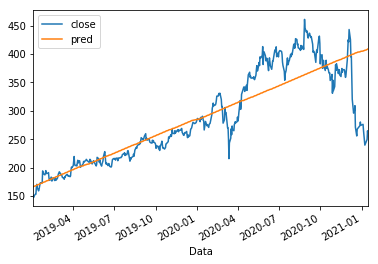

In [5]:
from sklearn.linear_model import LinearRegression

dr = df[df.index > '2019-01-01']

X = np.asarray(range(0,len(dr))).reshape(-1, 1)
Y = dr['close'].to_numpy().reshape(-1, 1)
linear_regressor = LinearRegression()
linear_regressor.fit(X, Y)

dr['pred'] = linear_regressor.predict(X)

dr.plot()

Regresja nieliniowa

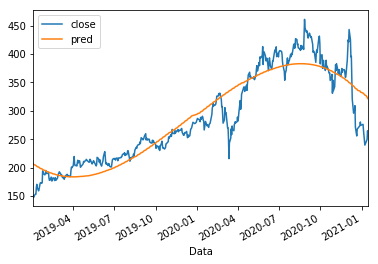

In [6]:
from scipy.optimize import curve_fit


def func(x, a, b, c, d, e, f, g):
    return (a * x) + (b * x**2) + (c * x**3) + e 

dr = df[df.index > '2019-01-01']

X = np.asarray(range(0,len(dr))).flatten()
Y = dr['close'].to_numpy().flatten()

opt, pcov = curve_fit(func, X, Y)

pred = np.zeros((len(X)))
for i in X:
    a, b, c, d, e, f, g = opt
    pred[i] = func(i, a, b, c, d, e, f, g)

dr['pred'] = pred
dr.plot()

średnia krocząca

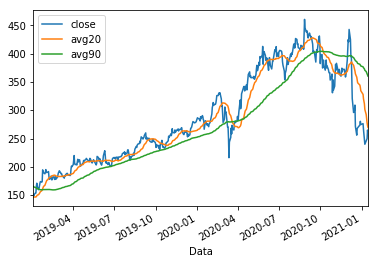

In [8]:
dr = df[df.index > '2019-01-01']
dr['avg20'] = df.rolling(window=20).mean()[df.index > '2019-01-01']
dr['avg90'] = df.rolling(window=90).mean()[df.index > '2019-01-01']
dr.plot()

gain dla różnych średnich kroczących

In [9]:
for len in range(10, 100, 10):
    dr = df[df.index > '2019-01-01']
    dr['avg'] = df.rolling(window=len).mean()[df.index > '2019-01-01']
    dr[['p_close', 'p_avg']] = dr[['close', 'avg']].shift(periods=1).fillna(method='bfill')

    positive_mask = (dr['close'] > dr['avg']) 
    buy_mask = positive_mask & ~positive_mask.shift(periods=1).fillna(False)
    close_buy_mask = ~positive_mask & positive_mask.shift(periods=1).fillna(False)

    #gain %
    gain = np.sum((dr['close'].loc[close_buy_mask].to_numpy()-dr['close'].loc[buy_mask].to_numpy()[:np.sum(close_buy_mask)])/dr['close'].loc[buy_mask].to_numpy()[:np.sum(close_buy_mask)])

    print('len:%d gain:%.2f%% num_trans:%d' %(len, 100*gain, np.sum(close_buy_mask)))

len:10 gain:67.64% num_trans:42
len:20 gain:19.86% num_trans:32
len:30 gain:32.51% num_trans:31
len:40 gain:48.78% num_trans:22
len:50 gain:50.68% num_trans:15
len:60 gain:49.56% num_trans:15
len:70 gain:46.61% num_trans:13
len:80 gain:54.10% num_trans:13
len:90 gain:82.94% num_trans:8


gain LONG / SHORT

In [11]:
for len in range(10, 100, 10):
    dr = df[df.index > '2019-01-01']
    dr['avg'] = df.rolling(window=len).mean()[df.index > '2019-01-01']
    dr[['p_close', 'p_avg']] = dr[['close', 'avg']].shift(periods=1).fillna(method='bfill')

    positive_mask = (dr['close'] > dr['avg']) 
    buy_mask = positive_mask & ~positive_mask.shift(periods=1).fillna(False)
    close_buy_mask = ~positive_mask & positive_mask.shift(periods=1).fillna(False)
    negative_mask = (dr['close'] < dr['avg']) 
    sell_mask = negative_mask & ~negative_mask.shift(periods=1).fillna(False)
    close_sell_mask = ~negative_mask & negative_mask.shift(periods=1).fillna(False)

    gainL = np.sum(dr['close'].loc[close_buy_mask].to_numpy()-dr['close'].loc[buy_mask].to_numpy()[:np.sum(close_buy_mask)])
    gainS = np.sum(dr['close'].loc[sell_mask].to_numpy()[:np.sum(close_sell_mask)]-dr['close'].loc[close_sell_mask].to_numpy())
    print('len:%d gain_long:%.2f gain_short:%.2f' %(len, gainL, gainS))

len:10 gain_long:132.00 gain_short:23.40
len:20 gain_long:-8.90 gain_short:-219.90
len:30 gain_long:42.10 gain_short:-168.90
len:40 gain_long:89.80 gain_short:-121.20
len:50 gain_long:69.80 gain_short:-141.20
len:60 gain_long:71.70 gain_short:-139.30
len:70 gain_long:77.90 gain_short:-133.10
len:80 gain_long:98.90 gain_short:-112.10
len:90 gain_long:172.30 gain_short:-71.70
